<h1>Segmentation of best localities in Hyderabad</h1>

<br>
<h3>Introduction</h3>
<p>In this Capstone project I'm using a scenario where a new family comes to Hyderabad for settling. The first problem they face was is which area is best to choose for residency. Hyderabad is a vast city which many localities. So, finding a best area with all the facilities is important. Every person wants a house that is near to hostipals, schools, parks etc. In project helps a person to find the best area for buying a new house.</p>

<br>
<h3>Business Problem</h3>
<p>The objective of this project is to determine the best neighborhood in hyderabad to buy a new house which is near to parks, restaurents, office etc. With the help of clustering, we would be able to determine the best neighborhood.</p>

<br>
<h3>Data</h3>
<p>To solve this problem, we will require following data :</p>
<ul>
    <li>Hyderabad localities list</li>
    <li>Average property rates per sqft in different localities</li>
    <li>Schools, Hospitals, Office near the area</li>
    <li>Places to visit in each area</li>
    <li>Latitude and Longitude of near area</li>
</ul>
    

<br>
<h3>Data Extraction</h3>
<ul>
    <li>Hyderabad localities and property rates from makaan.com using web scrapping</li>
    <li>Nearby schools, hostipal, places to visit in each area using Four Square API</li>
    <li>Latitude and Longitude dataset of near area using Geocoder package</li>
</ul>

In [20]:
from bs4 import BeautifulSoup
import requests

In [36]:
lnames = []
lprices = []
for i in range(1,22):
    url = "https://www.makaan.com/price-trends/property-rates-for-buy-in-hyderabad?page={}".format(i) 
    
    results = requests.get(url)

    soup = BeautifulSoup(results.content,"lxml")

    s_dt = soup.find_all("tr",{"itemtype":"http://schema.org/Place"})

    for i in range(0,60):
        pr = s_dt[i].find("td",{"class":"ta-r","itemtype":""}).text
        na = s_dt[i].a.text
      
        lnames.append(na)
        try:
            if("/" in pr):
                str_org_pri = pr.split("/")[0][1:-1]
                org_pri = float(str_org_pri.replace(",",""))
                lprices.append(org_pri)
            else:
                lprices.append(0)
        except:
            pass
        

In [41]:
from geopy.geocoders import Nominatim
geol = Nominatim(user_agent="foursquare_agent")

In [2]:
import pymysql
db = pymysql.connect("localhost","root","root","ibm")
cursor = db.cursor()

In [43]:
ll = []
for i,j in zip(lnames,lprices):
    try:
        x = i
        l = geol.geocode(x)
        #print("{},{}".format(x,l.latitude))
        lat = l.latitude
        lng = l.longitude
        sql = "insert into data values('{}',{},{},{})".format(x,lat,lng,j)
        cursor.execute(sql)
        db.commit()
        ll.append([lat,lng])
    except:
        pass

In [12]:
import folium
import pandas as pd

In [7]:
df = pd.DataFrame(columns=["name","latitude","longitude"])

In [8]:
sql = "select * from data"
cursor.execute(sql)
rows = cursor.fetchall()
for row in rows:
    df.loc[len(df)] = [row[0],row[1],row[2]]

In [23]:
n_pl = {}
for i in range(0,len(df)):
    u = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}'.format(CLIENT_ID, CLIENT_SECRET,df.loc[i]['latitude'],df.loc[i]['longitude'], VERSION, 5000)
    result = requests.get(u).json()
    count = len(result['response']['venues'])
    n_pl[df.loc[i]['name']]=count

In [ ]:
for i in n_pl:
    sql = "insert into place values('{}',{})".format(i,n_pl[i])
    cursor.execute(sql)
    db.commit
    break

In [17]:
final = pd.DataFrame(columns=['name','price','count','lat','lng'])

In [19]:
sql ='select data.locality,data.price,place.count,data.lat,data.lng from data inner join place on data.locality=place.name and data.price!=0;'
cursor.execute(sql)
rows = cursor.fetchall()
for row in rows:
    final.loc[len(final)] = [row[0],row[1],row[2],row[3],row[4]]

In [9]:
from sklearn.cluster import KMeans

In [67]:
kmean = KMeans(n_clusters = 3)
kmean.fit(final[['price','count']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [25]:
import matplotlib.pyplot as plt

In [68]:
res = kmean.predict(final[['price','count']])

In [69]:
res

array([2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [51]:
import numpy as np

In [58]:
WCSS_array=np.array([])
for K in range(1,11):
    kmeans=KMeans(n_clusters=K)
    kmeans.fit(final[['price','count']])
    Output=kmeans.predict(final[['price','count']])
    Centroids = kmeans.cluster_centers_
    wcss=0
    for k in range(K):
        wcss+=np.sum((Output[k+1]-Centroids[k,:])**2)
    WCSS_array=np.append(WCSS_array,wcss)

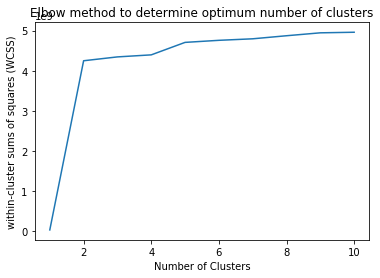

In [59]:
K_array=np.arange(1,11,1)
plt.plot(K_array,WCSS_array)
plt.xlabel('Number of Clusters')
plt.ylabel('within-cluster sums of squares (WCSS)')
plt.title('Elbow method to determine optimum number of clusters')
plt.show()

In [75]:
import folium

In [86]:
map_cluster = folium.Map(location=[17.3850,78.4867],zoom_start=11)
for lat,lng,name,value in zip(final['lat'],final['lng'],final['name'],res):
    label = folium.Popup(name)
    if(value==2):
        folium.CircleMarker(
        [lat,lng],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_opacity=0.7
        ).add_to(map_cluster)
    else:
        folium.CircleMarker(
        [lat,lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_opacity=0.7
    ).add_to(map_cluster)
    
    
    
map_cluster    